# Seasonal Effects

When predicting the outcome of a future match, we must for the most part rely on historical match data to provide numerical estimates of predictive factors. Within each season we
face the problem of data scarcity and estimator variability, since the number of matches only increases over the season. Hence, an aggregation of pre-season match data might be useful for providing prior estimates of quantities of interest.
The purpose of this notebook is to examine what effect, if any, that historical seasonal match data has on predictability.

## Define the imports

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
import match_tools
import stats_tools
from stats_tools import logit, logistic

In [5]:
from core_dist import no_intercept, add_intercept
from beta_dist import BetaDistribution
from bernoulli_dist import BernoulliDistribution

## Load the data

### Load match results

In [6]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [7]:
match_tools.add_timestamp(df_matches)

In [8]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type,timestamp
0,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,3,4,89,0,False,False,True,defeated,1990-03-31 14:10:00
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,7,10,6,192,4,True,False,False,lost-to,1990-03-31 14:10:00
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,3,6,5,104,4,True,False,False,lost-to,1990-03-31 14:10:00
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,3,2,4,60,0,False,False,True,defeated,1990-03-31 14:10:00
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,3,3,2,74,0,False,False,True,defeated,1990-03-31 19:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,4,5,4,82,4,True,False,False,lost-to,2022-07-16 17:30:00
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,2,2,5,85,4,True,False,False,lost-to,2022-07-16 19:25:00
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,2,3,0,77,0,False,False,True,defeated,2022-07-17 13:10:00
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,3,3,3,69,0,False,False,True,defeated,2022-07-17 14:50:00


### Load end-of-season statistics

In [9]:
df_seasonal = pd.read_csv(os.path.join("..", "data", "end_season_features.csv"))

In [10]:
df_seasonal

,season,team,teams,games,wins,draws,losses,wins_ratio,points_for,points_against,...,behinds_against,accuracy_against,goals_ratio,behinds_ratio,rank,rank_score,wins_prestige,adj_wins_prestige,points_prestige,adj_points_prestige
0,1990,Brisbane Bears,14,22,4,0,18,0.181818,1733,2426,...,338,0.507289,0.415126,0.426146,14,0.000000,0.003774,0.046936,0.049030,0.401289
1,1990,Carlton,14,22,11,0,11,0.500000,2277,2187,...,315,0.497608,0.517774,0.458763,8,0.461538,0.055508,0.433112,0.073333,0.507091
2,1990,Collingwood,14,26,19,1,6,0.750000,2798,2077,...,313,0.484349,0.578797,0.544396,1,1.000000,0.232418,0.797419,0.096696,0.581871
3,1990,Essendon,14,25,18,0,7,0.720000,2742,2079,...,297,0.500000,0.571429,0.552036,2,0.923077,0.172837,0.730920,0.096170,0.580403
4,1990,Fitzroy,14,22,7,0,15,0.318182,1874,2389,...,319,0.519578,0.433498,0.476190,12,0.153846,0.019412,0.204675,0.057674,0.443097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,18,17,9,0,8,0.529412,1631,1418,...,200,0.503722,0.540724,0.496222,8,0.588235,0.035989,0.388251,0.058767,0.514896
541,2022,St Kilda,18,17,9,0,8,0.529412,1333,1311,...,195,0.488189,0.509235,0.472973,10,0.470588,0.052259,0.483842,0.057077,0.507158
542,2022,Sydney,18,17,11,0,6,0.647059,1546,1280,...,176,0.511111,0.549020,0.534392,6,0.705882,0.103283,0.661940,0.065234,0.542620
543,2022,West Coast,18,17,2,0,15,0.117647,1084,1888,...,202,0.581781,0.361364,0.391566,17,0.058824,0.008256,0.123970,0.032211,0.361357


In [11]:
print(df_seasonal.columns)

Index(['season', 'team', 'teams', 'games', 'wins', 'draws', 'losses',
       'wins_ratio', 'points_for', 'points_against', 'points_ratio',
       'goals_for', 'behinds_for', 'accuracy_for', 'goals_against',
       'behinds_against', 'accuracy_against', 'goals_ratio', 'behinds_ratio',
       'rank', 'rank_score', 'wins_prestige', 'adj_wins_prestige',
       'points_prestige', 'adj_points_prestige'],
      dtype='object')


In [12]:
print(df_seasonal.columns)

Index(['season', 'team', 'teams', 'games', 'wins', 'draws', 'losses',
       'wins_ratio', 'points_for', 'points_against', 'points_ratio',
       'goals_for', 'behinds_for', 'accuracy_for', 'goals_against',
       'behinds_against', 'accuracy_against', 'goals_ratio', 'behinds_ratio',
       'rank', 'rank_score', 'wins_prestige', 'adj_wins_prestige',
       'points_prestige', 'adj_points_prestige'],
      dtype='object')


In [13]:
all_seasons = sorted(set(df_seasonal.season))

# Exclude the last season
removed_season = all_seasons[-1]
all_seasons = all_seasons[:-1]
df_seasonal = df_seasonal.loc[df_seasonal.season < removed_season].copy()

## Intra-seasonal relationships

We begin by looking at the reliability of the various agglomerated statistics at the end of each season.
For example, the [*wins ratio*](3_feature_extraction.ipynb#Numbers-of-wins,-draws-and-losses
"Feature Extraction: Numbers of wins, draws and losses") 
measures the proportion of all games within a given season won by a team (with an adjustment for draws). This gives an objective measure of a team's strength or weakness for that season. However, the measure is coarse, since a loss by 1 point is no different to a loss by 100 points. A more refined measure would therefore take account of the points margin of wins and losses (with zero margin for a draw).
Such a measure is provided by the 
[*points ratio*](3_feature_extraction.ipynb#Points-for-and-against "Feature Extraction: Points for and against"),
although this quantity has a more subjective interpretation than the wins ratio.

Another feature of interest is the 
[*rank score*](3_feature_extraction.ipynb#League-ranking "Feature Extraction: League ranking"), 
which is derived from the league rankings.
Finally, the last direct feature of interest is the 
[*prestige score*](3_feature_extraction.ipynb#Prestige-scores "Feature Extraction: Prestige scores"), 
which measures the fictional flow of 
[prestige](3_feature_extraction.ipynb#Prestige-scores "Feature Extraction: Prestige scores") 
from losing teams to winning teams. 
Note that we utilise adjusted versions of both these measures,
which are normalised to be comparable between different seasons with different numbers of teams.

Apart from these direct measures of team strength, there also exist indirect measures.
For example, the
[*goal accuracy*](3_feature_extraction.ipynb#Scores-for-and-against "Feature Extraction: Scores for and against")
measures the proportion of scoring shots that are goals instead of behinds. 
Since 1 goal is worth 6 behinds, one might suppose that the team with a higher accuracy might likely outscore
its opponent. This is an indirect measure of team strength since it is computed only from the scoring shots, and does not take account of the number of shots on goal that missed and did not score any points.

Since the wins ratio measures the proportion of matches won, we might suppose, for convenience, that this score was sampled from a 
[conditional Beta distribution](./C_regression_models.ipynb#Beta-regression "Regression Models: Beta regression").  Since the predictive scores, e.g. the points ratio, etc., are themselves also proportions, then 
[appropriate features](./C_regression_models.ipynb#Beta-covariate "Regression Models: Beta covariate")
include a constant term, the logarithm of the score, and the logarithm of the complement of the score.

However, this is only an assumption, and we therefore constrast the Beta regression model with a simple
cubic model that makes no such distributional assumptions. Note that the cubic model is unconstrained, and is therefore not guaranteed to provide valid values in the interval $[0,1]$, especially when extrapolated outside of the interval of observed data. In practice, the two different models behave similarly, with variations typically only apparent at the extreme ends of the observed interval. Note that the cubic model was chosen because
it exhibits an "S"-shaped curve, somewhat similar to that of the logistic function used in Beta regression.

Our first test of the predictive effect of various features is to examine their relationships within the same
season. Note that this is not really a fair test, since the outcome of each match contributes to both
the wins ratio and the points ratio, and the wins (and draws) determine the match points from which the league rankings are derived (using points scored for ties). Our test, therefore is merely meant to be indicative in the sense that the various aggregated features should be strongly correlated with each other.

### Points ratio
<a id="intra-points-ratio" />

In [14]:
X = df_seasonal.points_ratio
Y = df_seasonal.wins_ratio

In [15]:
def fit_data(X, Y):
    # Fit Beta response variate with Beta explanatory variate
    print("Fitting Beta regression with Beta covariate...")
    Z = add_intercept(np.log(X), np.log(1-X))
    br = BetaDistribution().regressor()
    print('Fit:', br.fit(Y, Z))
    print('Independent param:', br.independent_parameters())
    print('Regression params:', br.regression_parameters())
    # Measure fit
    Y_beta = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_beta))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_beta))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_beta))
    # Predict smooth response
    x_values = np.linspace(min(X), max(X), 100)
    z_values = add_intercept(np.log(x_values), np.log(1 - x_values))
    y_beta = br.mean(z_values)
    # Compute data means
    stats = stats_tools.summarise_data(X, Y)
    x_means = stats[1]
    y_means = stats[2]
    y_se = stats[4]
    # Fit cubic for comparison"
    print("---")
    print("Fitting cubic regression...")
    Z2 = no_intercept(X, X**2, X**3)
    reg = LinearRegression().fit(Z2, Y)
    print('Independent param:', reg.intercept_)
    print('Regression params:', reg.coef_)
    Y_cubic = reg.predict(Z2)
    print("R^2:", stats_tools.R_squared(Y, Y_cubic))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_cubic))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_cubic))
    z_values = no_intercept(x_values, x_values**2, x_values**3)
    y_cubic = reg.predict(z_values)
    # Return standard plot data
    return [
        (X, Y, 'o', 'data'),
        (x_values, y_cubic, 'b', 'cubic'),
        (x_values, y_beta, 'r', 'Beta'),
        (x_means, y_means, 'k', 'bin mean'),
        (x_means, y_means + 2 * y_se, 'darkgrey', '2 std. err.'),
        (x_means, y_means - 2 * y_se, 'darkgrey', None)    
    ]

In [16]:
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (1.2806034511394646, 866, 9.82614283051575e-07)
Independent param: [20.69894208]
Regression params: [-0.2275767   3.51719431 -3.79836942]
R^2: 0.8819860939044418
cross-entropy: 0.6296144228783102
accuracy: 0.8908918406072106
---
Fitting cubic regression...
Independent param: 3.778113214829152
Regression params: [-27.042973    61.55470438 -41.19718316]
R^2: 0.8823067282866147
cross-entropy: 0.6295971594655881
accuracy: 0.8851992409867173


We observe that the points ratio features, namely $\ln R$ and $\ln(1-R)$,
have regression weights which are of approximately the same magnitude but of opposite sign. This indicates the presence of a strong (a)symmetry, which in turn implies that we might usefully use the simpler *logit* feature, namely $\ln R-\ln(1-R)$. This symmetry is to be expected from the fact that scored points are doubly counted,
once for the scoring team and once against the opposing team. Thus, the points ratios from a single match
must average exactly to one-half, and the overall points ratios for all teams in a given season will average to approximately one-half.

In [17]:
def plot_data(data):
    ls = []
    for x, y, c, l in data:
        plt.plot(x, y, c)
        if l is not None:
            ls.append(l)
    plt.legend(ls)

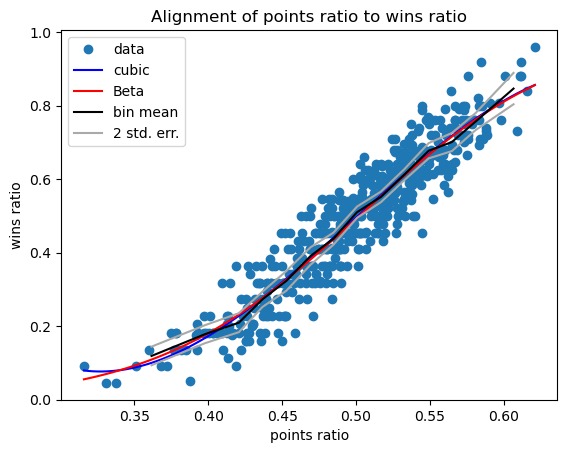

In [18]:
plot_data(data)
plt.xlabel('points ratio')
plt.ylabel('wins ratio')
plt.title('Alignment of points ratio to wins ratio')
plt.show()

We conclude that the points ratio provides a good predictor of the wins ratio.

### Adjusted rank score
<a id="intra-adjusted-rank-score" />

[Recall](3_feature_extraction.ipynb#League-ranking "Feature Extraction: League ranking")
that the rank score is a normalised score in $[0,1]$,
with the highest ranked team scoring 1 and the lowest ranked team scoring 0.
In order to permit logarithmic features, we need to adjust the
score into $(0,1)$.

In [19]:
# Map scores [0, 1] -> [0.1, 0.9] to avoid log(0) 
df_seasonal['adj_rank_score'] = X = 0.8 * df_seasonal.rank_score + 0.1

In [20]:
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (1.4172880844595404, 893, 9.892121766164053e-07)
Independent param: [27.12750975]
Regression params: [ 0.42215051  0.93378731 -0.37283453]
R^2: 0.9320124541906158
cross-entropy: 0.6262417672980235
accuracy: 0.9326375711574952
---
Fitting cubic regression...
Independent param: -0.035954287143029506
Regression params: [ 2.04154299 -2.72132743  1.63081688]
R^2: 0.9353127041692824
cross-entropy: 0.6259757401108715
accuracy: 0.9326375711574952


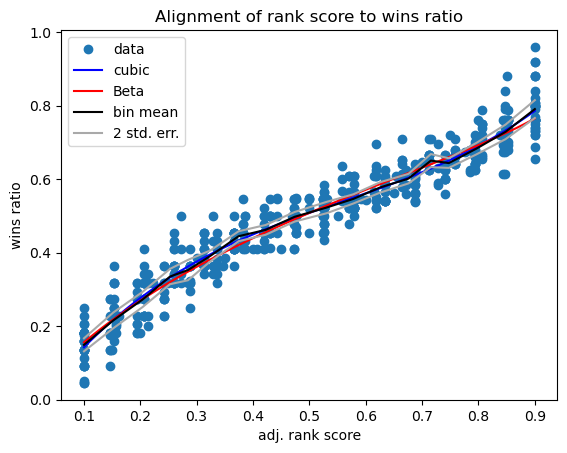

In [21]:
plot_data(data)
plt.xlabel('adj. rank score')
plt.ylabel('wins ratio')
plt.title('Alignment of rank score to wins ratio')
plt.show()

We conclude that the rank score provides a good predictor of the wins ratio.

### Adjusted wins prestige
<a id="intra-adjusted-wins-prestige" />

In [22]:
X = df_seasonal.adj_wins_prestige
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (1.1731101552520877, 843, 9.889872072399442e-07)
Independent param: [16.81093679]
Regression params: [-0.29197863  0.3920472  -1.09574794]
R^2: 0.8703195967979951
cross-entropy: 0.6303007395680645
accuracy: 0.8851992409867173
---
Fitting cubic regression...
Independent param: 0.09185861864219558
Regression params: [ 1.54810227 -1.83844056  1.25184397]
R^2: 0.8759374515125739
cross-entropy: 0.6299431592979413
accuracy: 0.8776091081593927


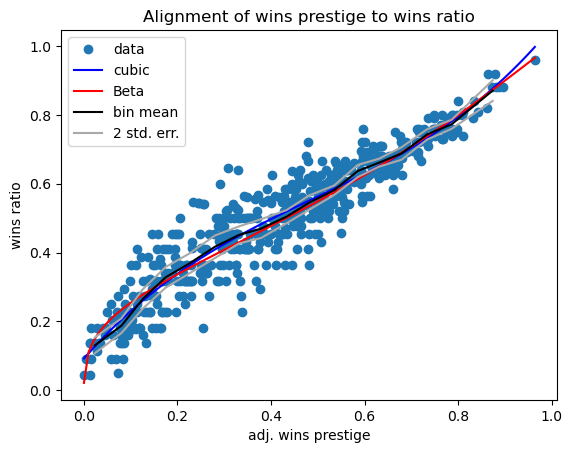

In [23]:
plot_data(data)
plt.xlabel('adj. wins prestige')
plt.ylabel('wins ratio')
plt.title('Alignment of wins prestige to wins ratio')
plt.show()

We conclude that the wins prestige provides a reasonable predictor of the wins ratio.

### Adjusted points prestige

In [24]:
X = df_seasonal.adj_points_prestige
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (1.2021075831232744, 849, 9.828076195095292e-07)
Independent param: [17.73218953]
Regression params: [-0.01045635  3.37954452 -3.41662433]
R^2: 0.8643496881302293
cross-entropy: 0.6310391102581837
accuracy: 0.8757115749525617
---
Fitting cubic regression...
Independent param: 3.204459301443971
Regression params: [-23.56166426  55.11679438 -37.5491356 ]
R^2: 0.8650425193004638
cross-entropy: 0.6309864578599309
accuracy: 0.8719165085388995


We observe that the points prestige shows the same (a)symmetry in the regression weights as
occurred for the [points ratio](#intra-points-ratio "Section: Points ratio"), presumably for the same reason of double counting of the points scored. Note that this is in contrast to the
[*wins* prestige](#intra-adjusted-wins-prestige "Section: Adjusted wins prestige"), which instead counts matches won and lost.

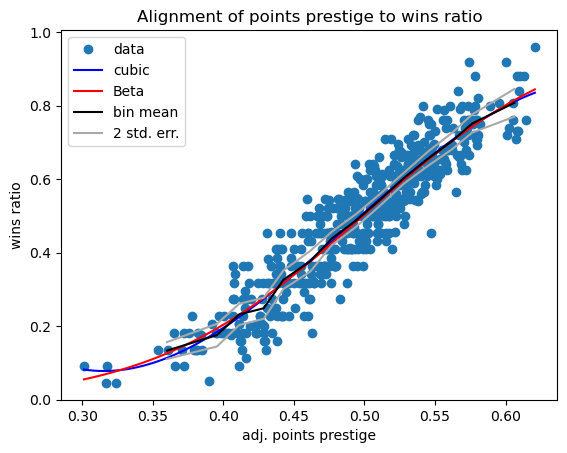

In [25]:
plot_data(data)
plt.xlabel('adj. points prestige')
plt.ylabel('wins ratio')
plt.title('Alignment of points prestige to wins ratio')
plt.show()

Note that the *points* prestige is a finer measure than the *wins* prestige (for the reasons outlined above), and hence exhibits a less extreme
range of values, closer to that of the [points ratio](#intra-points-ratio "Section: Points ratio").
We conclude that the points prestige provides a good predictor of the wins ratio.

### Goal accuracy

In [26]:
X = df_seasonal.accuracy_for
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.339010111494188, 637, 9.844462152130973e-07)
Independent param: [3.33909232]
Regression params: [16.99062836 15.31983582  9.63187694]
R^2: 0.12127741767991962
cross-entropy: 0.6846986406662015
accuracy: 0.6404174573055028
---
Fitting cubic regression...
Independent param: 2.6538649128481624
Regression params: [-23.94268031  62.75367925 -47.61725634]
R^2: 0.12328155361571924
cross-entropy: 0.6845642282774764
accuracy: 0.6290322580645161


We note that the goal accuracy, say $G$, is a proportion with corresponding features $\ln G$ and $\ln(1-G)$.
However, we observe that the regression weights for these features are both positive. This is
counter-intuitive, since we anticipated that teams with a high accuracy,
i.e. high $\ln G$, should be more likely to win than teams with a low accuracy, i.e. high $\ln(1-G)$.

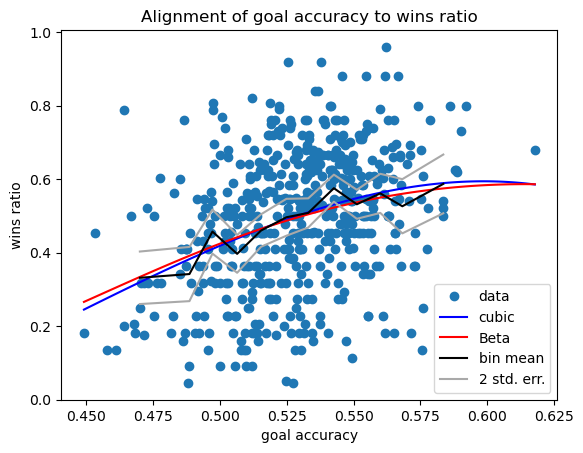

In [27]:
plot_data(data)
plt.xlabel('goal accuracy')
plt.ylabel('wins ratio')
plt.title('Alignment of goal accuracy to wins ratio')
plt.show()

We conclude that the goal accuracy, being only an indirect measure of team strength, is not sufficiently informative (on its own) to make a good predictor of the wins ratio. Clearly, a team with a low ratio of goals to points may still defeat an opposing team with a higher ratio if it scores a large enough number of points.
In fact, this is not an uncommon occurrence in practice.

### Summary

We conclude that the seasonal features are, as expected, mostly strongly correlated with each other *within the same season*. The exception appears to be the goal scoring accuracy, which seems to be too indirect a measure
to be a reliable predictor.

## Inter-seasonal relationships

Our next test is a fairer one, and examines the relationships between the features computed both at the end of one season and at the end of the next season. Such relationships directly indicate how strongly the results of  one season may be used to predict the next. The '*business as usual*' or *null* hypothesis is that one season is much like the next, subject to chance fluctuations. Mitigating against this hypothesis is the fact that,
as noted in the 
[introduction](1_introduction.ipynb#Temporal-heterogeneity "Introduction: Temporal heterogeneity"), 
teams change in player composition from season to season, and thus change in attacking and defending capabilities over time,
so that in some seasons a team might be systematically stronger or weaker than in other seasons.
This latter issue also suggests that there might be a 
reversion-to-the-mean effect, such that a good or bad season for any given team might likely be followed by a more average season.

In [28]:
def inter_seasonal_features(prev_field, cur_field):
    prev_values = []
    cur_values = []
    it = iter(all_seasons)
    prev_season = next(it)
    prev_features = df_seasonal[df_seasonal.season == prev_season]
    for cur_season in it:
        cur_features = df_seasonal[df_seasonal.season == cur_season]
        for idx, team_features in cur_features.iterrows():
            team = team_features['team']
            ind = prev_features.team == team
            if not any(ind):
                # Team is new, or has merged or changed name
                continue
            cur_values.append(team_features[cur_field])
            prev_value = prev_features.loc[ind, prev_field].values[0]
            prev_values.append(prev_value)
        prev_features = cur_features
    return np.array(prev_values), np.array(cur_values)

### Wins ratio

In [29]:
X, Y = inter_seasonal_features('wins_ratio', 'wins_ratio')

In [30]:
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.44103647102190274, 666, 9.913622658341836e-07)
Independent param: [4.05760573]
Regression params: [ 0.0323374   0.47785669 -0.39945628]
R^2: 0.2947106192817811
cross-entropy: 0.6727245890509534
accuracy: 0.6765873015873016
---
Fitting cubic regression...
Independent param: 0.14105560416264462
Regression params: [ 1.29404589 -1.80688452  1.27396573]
R^2: 0.2991179459804596
cross-entropy: 0.6724178503400808
accuracy: 0.6765873015873016


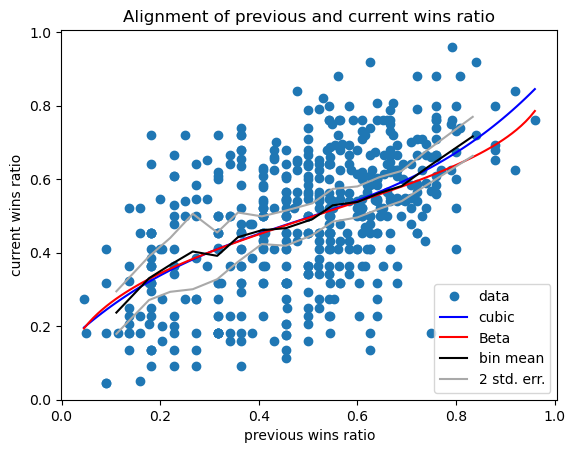

In [31]:
plot_data(data)
plt.xlabel('previous wins ratio')
plt.ylabel('current wins ratio')
plt.title('Alignment of previous and current wins ratio')
plt.show()

Firstly, we observe that the inter-seasonal effect is fairly weak, with the unmodelled variations being quite
large. Secondly, the assumption of a Beta distribution is questionable. Despite this, the response of the Beta model is similar to that of the cubic model, except at the higher end of the interval.
Lastly, we observe that there seems to be a reversion-to-the-mean effect, such that a high wins ratio for a team in one season is followed (on average) by a lower wins ratio the next season, and a low wins ratio in one season is followed (on average) by a higher wins ratio the next season.

### Points ratio

In [32]:
X, Y = inter_seasonal_features('points_ratio', 'wins_ratio')

In [33]:
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.4575281633073601, 672, 9.935046652032042e-07)
Independent param: [4.18573646]
Regression params: [ 1.42631883  2.90775257 -0.80967881]
R^2: 0.31670103045153297
cross-entropy: 0.6711559134226869
accuracy: 0.6865079365079365
---
Fitting cubic regression...
Independent param: -2.1898476351506684
Regression params: [ 13.21258494 -24.42318242  17.45063207]
R^2: 0.32146826014810215
cross-entropy: 0.6707471596862893
accuracy: 0.6845238095238095


We observe the the regression weights for the inter-seasonal points ratio features do not have the
same magnitude, unlike the intra-seasonal [points ratio](#intra-points-ratio "Section: Points ratio").
This is interesting, and demonstrates that we cannot simply assume that the logit feature is always applicable.

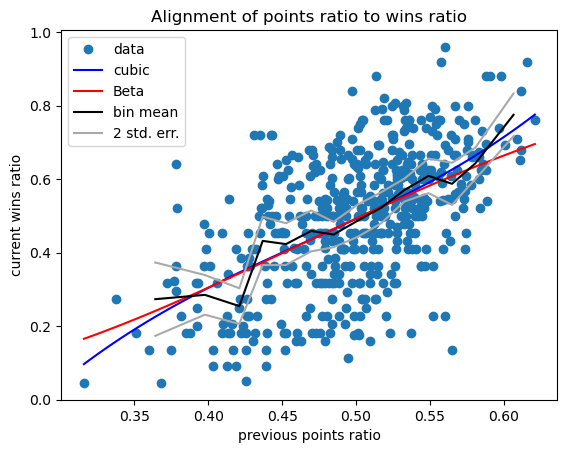

In [34]:
plot_data(data)
plt.xlabel('previous points ratio')
plt.ylabel('current wins ratio')
plt.title('Alignment of points ratio to wins ratio')
plt.show()

Clearly, the *inter*-seasonal predictions are weaker than the 
[*intra*-seasonal](#intra-points-ratio "Section: Points ratio")
predictions, with a much lower $R^2$ score and wider bands of variation.
Also, the Beta regression does not
seem to fit the upper end of the interval very well, whereas the cubic model seems to fit better,
although there are fewer observations at the extremes to provide good estimates.

### Adjusted rank score

In [35]:
X, Y = inter_seasonal_features('adj_rank_score', 'wins_ratio')
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.42766728192880155, 662, 9.857329041351726e-07)
Independent param: [3.95640945]
Regression params: [ 0.06915181  0.37259788 -0.23299489]
R^2: 0.2774134476392408
cross-entropy: 0.6740342782856492
accuracy: 0.6706349206349206
---
Fitting cubic regression...
Independent param: 0.14720003432153417
Regression params: [ 1.6734567  -2.86385874  1.8446724 ]
R^2: 0.2851885123399043
cross-entropy: 0.6734675526312937
accuracy: 0.6706349206349206


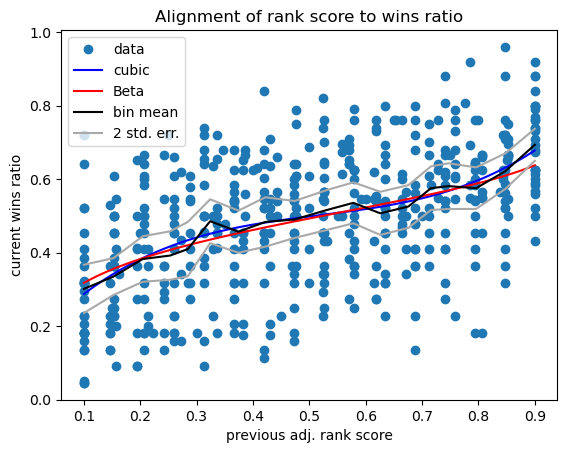

In [36]:
plot_data(data)
plt.xlabel('previous adj. rank score')
plt.ylabel('current wins ratio')
plt.title('Alignment of rank score to wins ratio')
plt.show()

Once again, the inter-seasonal predictions are much weaker than the 
[intra-seasonal](#intra-adjusted-rank-score "Section: Adjusted rank score")
predictions. In addition, the pattern of variation is very wide and almost uniform, although there is a slight
mean trend.
We observe that the lowest ranked team from one season may perform very well in the following season,
and the highest ranked team may perform badly.

In [37]:
X, Y = inter_seasonal_features('adj_rank_score', 'adj_rank_score')
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.22235563381674886, 598, 9.996247054833152e-07)
Independent param: [2.20638939]
Regression params: [ 0.22377021  0.51389599 -0.23015859]
R^2: 0.2569586264504231
cross-entropy: 0.6615064624585614
accuracy: 0.6617063492063492
---
Fitting cubic regression...
Independent param: 0.06254870362641873
Regression params: [ 2.13798296 -3.74680461  2.46896591]
R^2: 0.26994858273116673
cross-entropy: 0.6596946788943435
accuracy: 0.6617063492063492


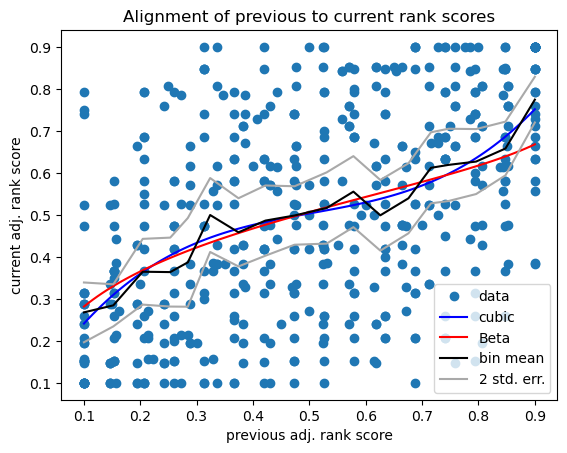

In [38]:
plot_data(data)
plt.xlabel('previous adj. rank score')
plt.ylabel('current adj. rank score')
plt.title('Alignment of previous to current rank scores')
plt.show()

In fact, it is difficult to see that the rank score provides much predictability for the next season at all.

### Adjusted wins prestige
<a id="inter-adjusted-wins-prestige" />

In [39]:
X, Y = inter_seasonal_features('adj_wins_prestige', 'wins_ratio')
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.420238283092948, 659, 9.991215640936524e-07)
Independent param: [3.9009259]
Regression params: [-0.1265537   0.19397113 -0.47667304]
R^2: 0.2629215159816287
cross-entropy: 0.6750026211097977
accuracy: 0.6607142857142857
---
Fitting cubic regression...
Independent param: 0.22976562842401832
Regression params: [ 1.39487035 -2.53089995  1.84330952]
R^2: 0.2718449515069783
cross-entropy: 0.6743213999773855
accuracy: 0.6607142857142857


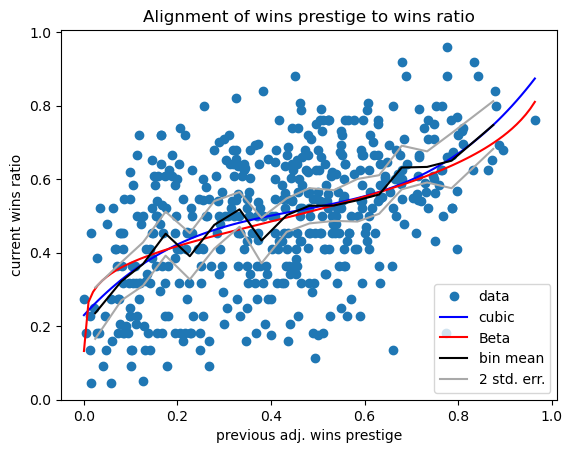

In [40]:
plot_data(data)
plt.xlabel('previous adj. wins prestige')
plt.ylabel('current wins ratio')
plt.title('Alignment of wins prestige to wins ratio')
plt.show()

As usual, the inter-seasonal predictions are weaker than the 
[intra-seasonal](#intra-adjusted-wins-prestige "Section: Adjusted wins prestige")
predictions, with much more variance.
It is also interesting to note the difference between the two models at the lower
end of the interval, where the Beta model approaches zero asymptotically, but the cubic model predicts a distinctly non-zero response.

### Adjusted points prestige

In [41]:
X, Y = inter_seasonal_features('adj_points_prestige', 'wins_ratio')
data = fit_data(X, Y)

Fitting Beta regression with Beta covariate...
Fit: (0.4531830268072884, 671, 9.854497204364598e-07)
Independent param: [4.15202494]
Regression params: [ 1.72979644  2.96681676 -0.47180008]
R^2: 0.3081426308232972
cross-entropy: 0.6717422900250277
accuracy: 0.6726190476190477
---
Fitting cubic regression...
Independent param: -1.7010513721269849
Regression params: [ 10.23260026 -18.03229826  12.74008304]
R^2: 0.3122681454493882
cross-entropy: 0.6714162413143443
accuracy: 0.6765873015873016


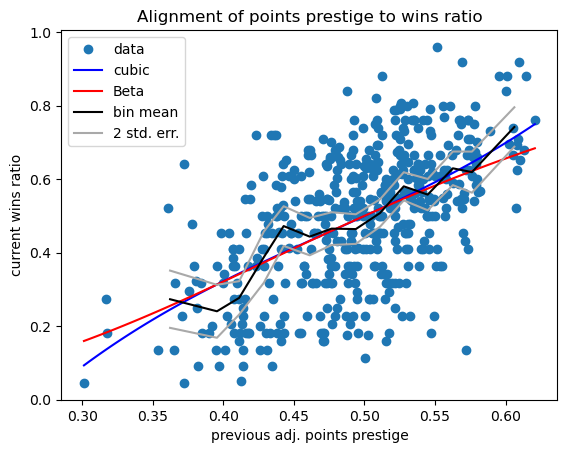

In [42]:
plot_data(data)
plt.xlabel('previous adj. points prestige')
plt.ylabel('current wins ratio')
plt.title('Alignment of points prestige to wins ratio')
plt.show()

It is interesting to observe the nearly linear response of the points prestige score,
in contrast to the sharply curved response of the
[wins prestige](#inter-adjusted-wins-prestige "Section: Adjusted wins prestige") score.

### Summary

As was to be expected, there is a larger amount of variability for inter-seasonal prediction compared to intra-seasonal prediction, but there do seem to be weakly positive associations between the various scores for consecutive seasons. We conclude that team results from the past season might have some influence on the performance of the team in the current season, but that this influence might wane as the current season progresses. 
This suggests that the end-of-season statistics might be more usefully employed as prior information for the
next season.

## Inter-seasonal match prediction

In the [previous](#Inter-seasonal-relationships "Section: Inter-seasonal relationships")
section, we only examined
[one-team](1_introduction.ipynb#Logistic-models "Introduction: Logistic models")
models that attempted to predict the end-of-season statistics for each team given that team's statistics
from the previous season.
However, since each match is between a pair of opposing teams,
we eventually need to take some account of the statistics from both teams, via two-team models.

In the [next](5_match_effects.ipynb "Chapter 5: Match Effects") chapter, we shall examine in detail the predictability of individual matches using intra-seasonal information that is dynamically updated as the season progresses.
In contrast, here we shall examine the overall predictability of matches in the current season using only
static information from the previous season. However, we shall take account of the information available for both teams for each match.

Under the "*business as usual*" hypothesis that team performance remains approimately the same from one season to the next, the relative difference in scores between two opposing teams should provide some predictability of the
outcome of each match.
We note that the match outcome (from the perspective of a given team) is a Bernoulli variable, and hence
we assume for convenience that the response variate is drawn from a
[conditional Bernoulli distribution](./C_regression_models.ipynb#Bernoulli-regression "Regression Models: Bernoulli regression"). 

Finally, since all of our explanatory covariates are proportions, we shall take the customary logarithmic
features. However, since we sometimes [found](#intra-points-ratio "Section: Points ratio") that the
logit feature might be equally applicable, we also fit the corresponding logit regression model for comparison.

### Wins ratio

In [43]:
def prev_season_statistics(team, season):
    ind = (df_seasonal.team == team) & (df_seasonal.season == season - 1)
    df = df_seasonal[ind]
    if len(df) == 0:
        return None
    else:
        return next(df.itertuples())

In [44]:
match_statistics = []
for match in df_matches.itertuples():
    for_stats = prev_season_statistics(match.for_team, match.season)
    if for_stats is None:
        continue
    against_stats = prev_season_statistics(match.against_team, match.season)
    if against_stats is None:
        continue
    res = match_tools.get_match_result(match, is_for=True)
    wins_ratio = 0.5 * (res + 1)
    match_statistics.append((for_stats, against_stats, wins_ratio))

In [45]:
def get_variates(stats_name):
    Y = []
    X_for = []
    X_against = []
    for for_stats, against_stats, wins_ratio in match_statistics:
        x_for = getattr(for_stats, stats_name)
        x_against = getattr(against_stats, stats_name)
        # Perspective of 'for' team:
        Y.append(wins_ratio)
        X_for.append(x_for)
        X_against.append(x_against)
        # Perspective of 'against' team:
        Y.append(1 - wins_ratio)
        X_for.append(x_against)
        X_against.append(x_for)
    return np.array(X_for), np.array(X_against), np.array(Y)

In [46]:
def fit_data2(stats_name):
    X_for, X_against, Y = get_variates(stats_name)
    # Fit Bernoulli response variate with Beta explanatory variates
    print("Fitting Bernoulli regression with Beta features...")
    Z = no_intercept(np.log(X_for) - np.log(X_against), np.log(1 - X_for) - np.log(1 - X_against))
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z))
    print('Regression params:', br.regression_parameters())
    Y_bern = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_bern))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_bern))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_bern))
    # Fit Bernoulli response variate with symmetric Beta explanatory variates
    print("---")
    print("Fitting Bernoulli regression with a logit feature...")
    Z = no_intercept(logit(X_for) - logit(X_against))
    br = BernoulliDistribution().regressor()
    print('Fit:', br.fit(Y, Z))
    print('Regression params:', br.regression_parameters())
    Y_logit = br.mean(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_logit))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_logit))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_logit))
    # Fit cubic for comparison
    print("---")
    print("Fitting cubic regression...")
    X_diff = X_for - X_against
    Z = no_intercept(X_diff, X_diff**2, X_diff**3)
    reg = LinearRegression(fit_intercept=True).fit(Z, Y)
    print("Independent param:", reg.intercept_)
    print("Regression params:", reg.coef_)
    Y_cubic = reg.predict(Z)
    print("R^2:", stats_tools.R_squared(Y, Y_cubic))
    print("cross-entropy:", stats_tools.cross_entropy(Y, Y_cubic))
    print("accuracy:", stats_tools.binary_accuracy(Y, Y_cubic))
    # Return computations
    return stats_name, X_for, X_against, Y, Y_logit, Y_bern, Y_cubic

In [47]:
data = fit_data2('wins_ratio')

Fitting Bernoulli regression with Beta features...
Fit: (-0.6511527249890345, 3, 1.0724470100864636e-07)
Regression params: [ 0.49796579 -0.51764909]
R^2: 0.08092976124184625
cross-entropy: 0.6511527249890345
accuracy: 0.612603305785124
---
Fitting Bernoulli regression with a logit feature...
Fit: (-0.6511538335366254, 3, 1.0689345841807807e-07)
Regression params: [0.50717465]
R^2: 0.0809186513361394
cross-entropy: 0.6511538335366254
accuracy: 0.612603305785124
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [5.17952753e-01 1.66533454e-16 1.38459435e-01]
R^2: 0.08054162415071642
cross-entropy: nan
accuracy: 0.612603305785124


We note that the Bernoulli match outcome is a discrete variate, and so the $R^2$ measure of (continuous) correlation is not really appropriate. More appropriate is the classification accuracy of predicting the
match outcome. Observe that an accuracy of 61% indicates that the model predictions are slightly more likely to be
correct than incorrect, on average. Consequently, we conclude that the teams' wins ratios from the
previous season retain some predictive information that is relevant for the current season.

We also note that for the Beta features, say $\ln R$ and $\ln(1-R)$, the Bernoulli regression weights have similar magnitude but opposite signs. This suggests that for this case the features exhibit a strong (a)symmetry, and might be replaced by a single logit feature, namely $\ln R-\ln(1-R)$.
Under this logit feature, the corresponding regression weight is observed to be approximately an average of the Beta weight mgnitudes, and the corresponding model is almost equivalent in behaviour. Hence, under *Occam's razor*, we should prefer the simpler model. In addition, use of the single logit feature allows us to plot the responses of
the various models in two dimensions.

Finally, we observe that the unconstrained cubic model produced values outside of the range $[0,1]$,
which therefore prevented a valid cross-entropy score from being computed. Despite this problem, the cubic model was still able to predict match outcomes as accurately as the Bernoulli model.

In [48]:
def plot_data2(data):
    stats_name, X_for, X_against, Y, Y_logit, Y_bern, Y_cubic = data
    label = stats_name.replace("_", " ").replace("adj ", "adj. ")
    X = logit(X_for) - logit(X_against)
    stats = stats_tools.summarise_data(X, Y)
    x_means = stats[1]
    y_means = stats[2]
    y_se = stats[4]
    # Plot data and all models
    plt.plot(X, Y, 'o')
    plt.plot(X, Y_cubic, 'r.')
    plt.plot(X, Y_bern, 'b.')
    plt.plot(X, Y_logit, 'g.')
    plt.plot(x_means, y_means, 'k')
    plt.plot(x_means, y_means + 2 * y_se, 'darkgrey')
    plt.plot(x_means, y_means - 2 * y_se, 'darkgrey')
    plt.legend(['data', 'cubic', 'Beta', 'logit', 'bin mean', '2 std. err.'])
    plt.xlabel(f"$\Delta$ logit({label})")
    plt.ylabel("match wins ratio")
    plt.title(f"Match prediction using seasonal {label}")
    plt.show()

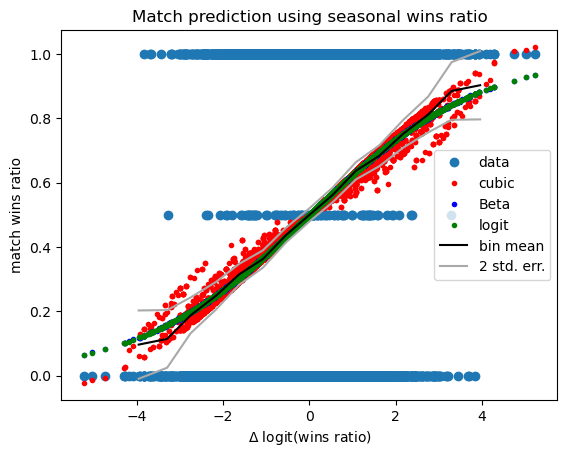

In [49]:
plot_data2(data)

We observe that the Bernoulli regression model with a logit feature provides some predictive capability using the wins ratio, and
completely replaces the model with Beta covariate features. We also observe the effect of the lack of constraints on the cubic model, which also exhibits some irregular behaviour.

### Points ratio

In [50]:
data = fit_data2('points_ratio')

Fitting Bernoulli regression with Beta features...
Fit: (-0.6477626820190389, 3, 2.1785553472319918e-07)
Regression params: [ 2.07714748 -2.2445006 ]
R^2: 0.086961996586148
cross-entropy: 0.6477626820190389
accuracy: 0.6138085399449036
---
Fitting Bernoulli regression with a logit feature...
Fit: (-0.647762987099227, 3, 1.449451350055142e-07)
Regression params: [2.15926946]
R^2: 0.08695975632724184
cross-entropy: 0.647762987099227
accuracy: 0.6138085399449036
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [ 1.98506413e+00 -1.88044025e-15 -3.89587632e-02]
R^2: 0.08728698717845862
cross-entropy: nan
accuracy: 0.6138085399449036


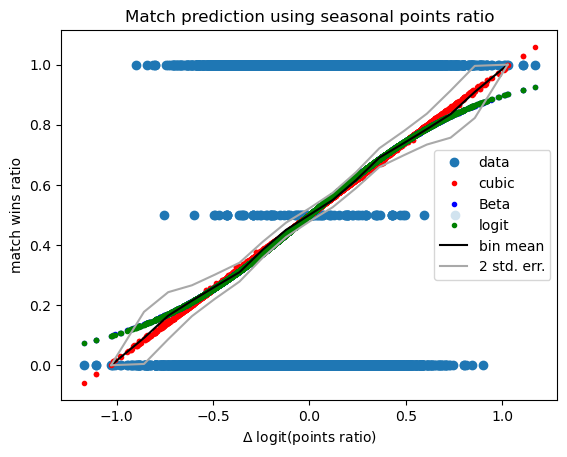

In [51]:
plot_data2(data)

For the points ratio, once again the logit feature usefully replaces the Beta features, and the cubic model has reasonable behaviour.

### Adjusted rank score

In [52]:
data = fit_data2('adj_rank_score')

Fitting Bernoulli regression with Beta features...
Fit: (-0.6544154639891869, 3, 1.8285663094808058e-08)
Regression params: [ 0.39588753 -0.29119307]
R^2: 0.0752644348612318
cross-entropy: 0.6544154639891869
accuracy: 0.6110537190082644
---
Fitting Bernoulli regression with a logit feature...
Fit: (-0.6544865623717467, 3, 1.6987717565974947e-08)
Regression params: [0.34292036]
R^2: 0.07516854027482878
cross-entropy: 0.6544865623717467
accuracy: 0.6110537190082644
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [ 3.52912036e-01 -4.44089210e-16  1.27205781e-01]
R^2: 0.07347845801891784
cross-entropy: 0.6552882458623821
accuracy: 0.6110537190082644


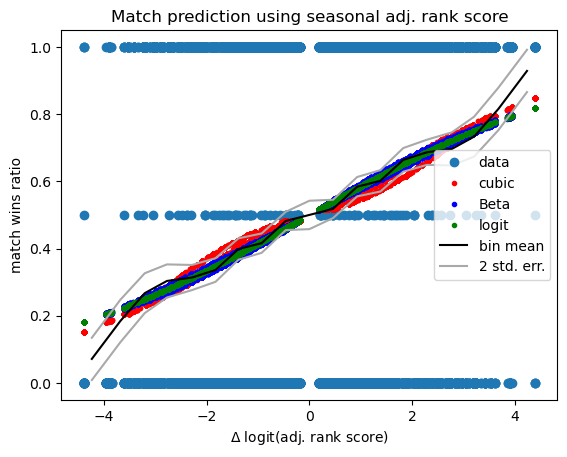

In [53]:
plot_data2(data)

For the rank score, we now observe that there is some apparent difference between the Bernoulli models using the logit feature and the Beta features,
respectively, and the cubic model also displays some uncertainty. None of the models appear to perform consistently
with the data at the extreme ends of the interval.

### Adjusted wins prestige

In [54]:
data = fit_data2('adj_wins_prestige')

Fitting Bernoulli regression with Beta features...
Fit: (-0.6533933889828933, 3, 8.920763168163148e-07)
Regression params: [ 0.33829621 -0.41464402]
R^2: 0.07714786266472873
cross-entropy: 0.6533933889828933
accuracy: 0.6110537190082644
---
Fitting Bernoulli regression with a logit feature...
Fit: (-0.6534341141971811, 3, 3.602465513674602e-07)
Regression params: [0.36607375]
R^2: 0.07717642201133579
cross-entropy: 0.6534341141971811
accuracy: 0.6110537190082644
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [4.40633790e-01 2.08166817e-17 2.72937572e-02]
R^2: 0.07372724095215888
cross-entropy: 0.655022620853176
accuracy: 0.6110537190082644


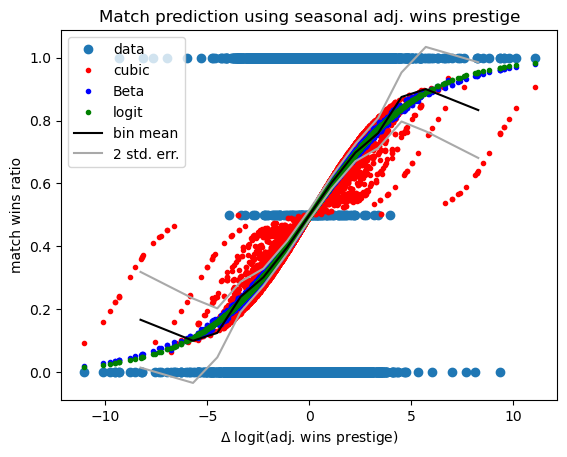

In [55]:
plot_data2(data)

For the wins prestige score, we observe that the Bernoulli models with logit and Beta features, respectively, perform similarly.
However, the cubic model, which relies not on logarithms but directly on the difference between team covariates,
exhibits irregular behaviour. Also note that the observed data seem to be sparse at the extemes of the interval,
due to the large uncertainty of the data means.

### Adjusted points prestige

In [56]:
data = fit_data2('adj_points_prestige')

Fitting Bernoulli regression with Beta features...
Fit: (-0.6486186989035856, 3, 2.73471908118772e-07)
Regression params: [ 2.72832978 -1.27146254]
R^2: 0.08545812463994373
cross-entropy: 0.6486186989035856
accuracy: 0.6181129476584022
---
Fitting Bernoulli regression with a logit feature...
Fit: (-0.6486479475914735, 3, 1.297160781010831e-07)
Regression params: [2.01700343]
R^2: 0.08540423183852897
cross-entropy: 0.6486479475914735
accuracy: 0.6181129476584022
---
Fitting cubic regression...
Independent param: 0.5
Regression params: [ 1.87494860e+00 -1.11022302e-15 -8.20762293e-01]
R^2: 0.08561975570797975
cross-entropy: nan
accuracy: 0.6181129476584022


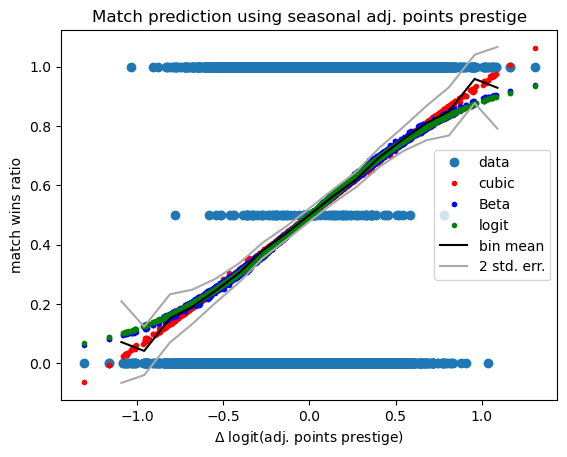

In [57]:
plot_data2(data)

For the points prestige score, the three constrasting models again appear to be reasonable. 

### Summary

We conclude that for two-team match prediction models with covariates that are probabilities or proportions,
we may take the appropriate team feature as the logit of the covariate.
We also conclude that the different end-of-season statistics we have examined above appear to provide weak predictive ability of the outcome of each match.

## Multi-seasonal prediction

In the previous sections,
we [examined](#Intra-seasonal-relationships "Section: Intra-seasonal relationships") 
the summary statistics aggregated over all matches per team within each season, and then examined the effect of predicting the 
[statistics](#Inter-seasonal-relationships "Section: Inter-seasonal relationships")
and [match outcomes](#Inter-seasonal-match-prediction "Section: Inter-seasonal match prediction") 
of each season
using only the previous season's statistics. Overall, there appeared to be weak but definite predictive effects.

This raises the question of whether incorporating further past seasons will boost the predictive effect.
On the one hand, using multiple seasons might provide some measure of variability, and thus aid in smoothing
over exceptionally good or bad seasons. On the other hand, team changes over time possibly mean that a season long past may be a poor predictor of the future.

The proportions of wins, draws and losses for a given team for a particular season measure that team's success against all other teams,
and provide a predictor of the next season. That is, the proportions may be interpreted as probabilities.
Hence, we shall take a 
[weighted average](A_additive_weights.ipynb "Appendix A: Additively Weighted Models")
of the past seasons' proportions as a predictor of the proportions for the
following season.

Equivalently, we intend to fit a linear auto-regressive model to seasonal, per-team time-series data.
In order to get a feel for how difficult this task is in practice, we plot the wins ratio time-series below.

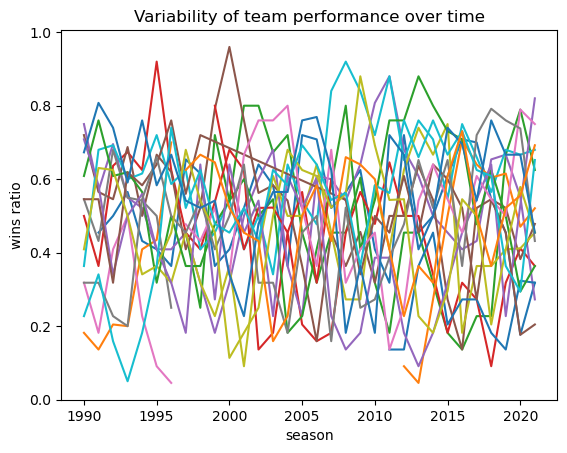

In [58]:
all_teams = sorted(set(df_seasonal.team))
for team in all_teams:
    team_data = df_seasonal.loc[df_seasonal.team == team, ['season', 'wins_ratio']]
    plt.plot(team_data.season, team_data.wins_ratio.values)
plt.title("Variability of team performance over time")
plt.xlabel('season')
plt.ylabel('wins ratio')
plt.show()

### Extract seasonal proportions

We start our modelling by estimating the overall proportion of drawn matches. Other than draws, we expect *a priori* that the proportions of wins and losses should be equal.

In [59]:
prob_draw = sum(df_seasonal.draws) / sum(df_seasonal.games)
prob_win = prob_loss = (1 - prob_draw) / 2
prior_probs = np.array([prob_win, prob_draw, prob_loss])
print(prior_probs)

[0.49559581 0.00880838 0.49559581]


Since draws are rare events, the accurate prediction of drawn matches is problematic. To help ease this problem, we smooth the per-season statistics with the global prior before computing the proportions.

In [60]:
stats = ['wins', 'draws', 'losses']
df_experim = df_seasonal[['season', 'team', 'games'] + stats].copy()
for field in stats:
    df_experim[field] = df_experim[field].astype(float)

df_experim[stats] = df_experim[stats].values + prior_probs
for field in stats:
    df_experim[field] = df_experim[field] / (df_experim.games + 1)

In [61]:
df_experim

,season,team,games,wins,draws,losses
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156
1,1990,Carlton,22,0.499809,0.000383,0.499809
2,1990,Collingwood,26,0.722059,0.037363,0.240578
3,1990,Essendon,25,0.711369,0.000339,0.288292
4,1990,Fitzroy,22,0.325895,0.000383,0.673722
...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287
523,2021,St Kilda,22,0.456330,0.000383,0.543287
524,2021,Sydney,23,0.645650,0.000367,0.353983
525,2021,West Coast,22,0.456330,0.000383,0.543287


We now collect the per-season proportions across all seasons for each team.

In [62]:
all_teams = sorted(set(df_experim.team))

team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, stats].values.copy()

### Temporal averaging

In order to measure the temporal effect of seasonal data, for each team we extract a collection of contexts and
targets. Each target represents the end-of-season statistics of a given team for a given season,
and the corresponding context represents the previous $K$ seasons of statistics.
In effect, for each team we take a sliding window of $K+1$ seasons as the training data.

In [63]:
from numpy.lib.stride_tricks import sliding_window_view

In [64]:
def get_target_contexts(team_data, num_context):
    values = next(iter(team_data.values()))
    num_classes = values.shape[1]  # C
    window_shape = (num_context + 1, num_classes)
    contexts = []  # N x K x C
    targets = []   # N x C
    for team, values in team_data.items():
        if values.shape[0] < window_shape[0]:
            # Too few seasons - ignore team
            continue
        sequences = sliding_window_view(values, window_shape)
        sequences = sequences[:, 0, :, :]
        contexts.append(sequences[:, :-1, :])
        targets.append(sequences[:, -1, :])
    contexts = np.vstack(contexts)
    targets = np.vstack(targets)
    return targets, contexts

Before we start the modelling, we should consider some aspects of both the data and the model.
Firstly, we only have about 30 years of data, due to our pre-determined date cut-off of 1990.
Hence, choosing $K\approx 30$ will run into problems with scarcity of data, thus affecting model fitting.
This problem should be reduced as $K$ becomes smaller, with $K\approx 15$ resulting in a sliding window of about 15 seasons to model about 15 future seasons. Beyond $K\approx 15$ might be problematic (i.e. producing untrustworthy results).

Secondly, we expect that as the number $K$ of model parameters increases, the model becomes more exprerssive and should fit the training data 
better and better (except near $K\approx 30$), thus typically leading to over-fitting. Furthermore, due to
the iterative nature of the parameter estimation, in the absence of parameter regularisation and model validation, we also expect over-fitting of the training data for any given $K$. Consequently, we should treat the interpretation of the resulting weights with some caution.

For convenience, we shall arbitrary take $K=15$ for the next analysis.

In [65]:
num_context = 15  # K
targets, contexts = get_target_contexts(team_data, num_context)
print(targets.shape)
print(contexts.shape)

(236, 3)
(236, 15, 3)


For the [additive model](A_additive_weights.ipynb#Additive-model
"Appendix A: Additive model"),
we give each season in the context a non-negative weight, say $w_k$, such that these weights sum to unity.
The overall prediction is then the weighted sum of the context.
We use
[quasi-supervised](A_additive_weights.ipynb#Quasi-Supervised-Training
"Appendix A: Quasi-Supervised Training")
training to choose these weights to minimise the cross-entropy of the context given the target.
Note that the contexts specify $P(c\mid\mathbf{x}_k^{(d)},\Theta)$, and the targets specify
$P(c\mid\vec{\mathbf{x}}^{(d)},\Gamma)$.

In [66]:
def score_weights(target_probs, context_probs, weights=None):
    num_context = context_probs.shape[1]  # K
    if weights is None:
        weights = np.ones(num_context) / num_context
    posterior_probs = [None] * num_context  # K x N x C
    # Compute P(k,c|x)
    for k in range(num_context):
        posterior_probs[k] = weights[k] * context_probs[:,k,:]
    # Compute P(c|x)
    predicted_probs = sum(posterior_probs)  # N x C
    # Compute L(Theta)
    L = np.mean(np.sum(target_probs * np.log(predicted_probs), axis=1))
    # Compute P(k|c,x)
    for k in range(num_context):
        posterior_probs[k] /= predicted_probs
    # Update P(k)
    new_weights = np.zeros(num_context)
    for k in range(num_context):
        new_weights[k] = np.mean(np.sum(target_probs * posterior_probs[k], axis=1))
    return L, new_weights

In [67]:
def iterate_estimates(target_probs, context_probs, tol=1e-8):
    scores = []
    L0, weights = score_weights(target_probs, context_probs)
    scores.append(L0)
    L1, weights = score_weights(target_probs, context_probs, weights)
    scores.append(L1)
    while L1 - L0 >= tol:
        L0 = L1
        L1, weights = score_weights(target_probs, context_probs, weights)
        scores.append(L1)
    return weights, scores

In [68]:
weights, scores = iterate_estimates(targets, contexts)
L1 = scores[-1]
L0 = scores[-2]
print(f"score={L1}, convergence={L1-L0}, #iterations={len(scores)}")
print("model weights:\n", weights)

score=-0.7198193632100739, convergence=9.97581506290146e-09, #iterations=1124
model weights:
 [7.14284458e-02 1.30747200e-02 3.70199044e-07 5.64091987e-02
 8.74928663e-02 1.67925672e-02 1.06680993e-03 1.22984977e-04
 6.59964929e-02 9.76020986e-06 3.01933786e-02 4.32734912e-02
 8.17450454e-02 4.03312412e-04 5.31990556e-01]


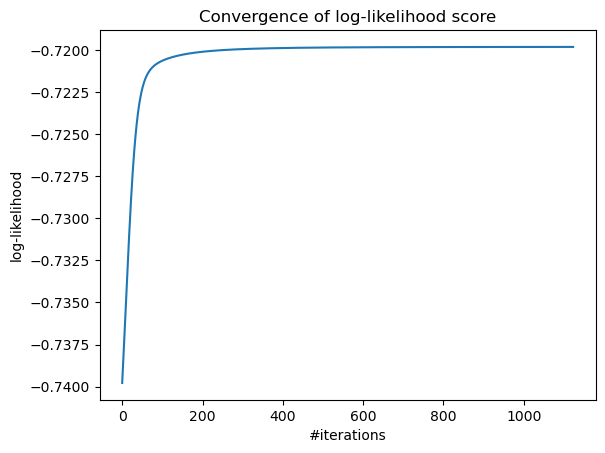

In [69]:
plt.plot(scores)
plt.title("Convergence of log-likelihood score")
plt.xlabel("#iterations")
plt.ylabel("log-likelihood")
plt.show()

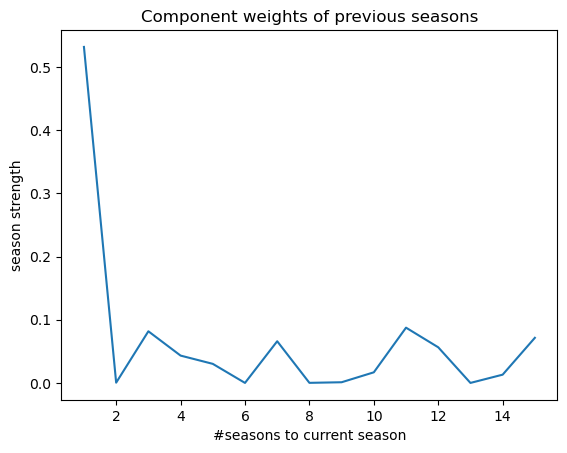

In [70]:
rweights = list(weights)
rweights.reverse()
steps = range(1, num_context + 1)

plt.plot(steps, rweights)
plt.title("Component weights of previous seasons")
plt.xlabel("#seasons to current season")
plt.ylabel("season strength")
plt.show()

We observe that the season immediately prior to a given season (say, $k=1$) is given the greatest weight (say $w_1$), with all other past seasons ($k>1$) given a low weight ($w_k$) of about the same magnitude, i.e. $\approx\frac{1}{K}$. 
In futher experiments (not shown here), this pattern persists irrespective of the number $K$ of
past seasons. We attach no significance to the variance in weights across the low-weighted seasons, since this oscillating variation also persists independently of $K$, except that the weights of past seasons may abitrarily be higher or lower as $K$ varies. We attribute this to over-fitting the data, as discussed above.

This pattern of weights also appears when optimisating models with other objective functions, e.g. linear regression using least square error (via stacking the $C$ classes of $N$ cases into $NC$ cases). Also note that, instead of a weighted additive model, one may use a weighted multiplicative model. Under the *logit* transform $\sigma^{-1}(p)=\ln\frac{p}{1-p}$ of the features, this may also be re-cast into a weighted additive model. Further experiments with this new model
also showed the same pattern of weights. In particular, use of `LassoCV`, i.e.
linear regression with an $L_1$ weight regulariser and using cross-validation, repeatedly gave zero or near-zero weights (for various values of $K$) for all except weight $w_1$, corresponding to $K=1$. The [next](#Predictive-accuracy "Section: Predictive accuracy") section explores some of these results for fitting linear regression models via `LassoCV`.

We conclude that, for the purposes of predicting the current season, only the previous season appears to hold sufficient information.

### Predictive accuracy

Despite the fact that the additive model gives most weight to $K=1$, there might still be some predictive advantage in having $K>1$.
Let us therefore look at the predictive accuracy of including further past seasons. 
However, this time we will model the wins ratio of the current season as a linear regression of past seasons, ussing `LassoCV` to include cross-validation and weight penalisation.

As discussed [earlier](#Temporal-averaging "Section: Temporal averaging"), 
we expect model over-fitting as $K$ increases.
In order to approximately measure the effect of over-fitting, for each value of $K$ we estimate the parameters from a random selection of 80% of the training data, and evalue the resulting model on the remaining 20%.

In [71]:
adj_wins = df_experim.wins + 0.5 * df_experim.draws
adj_losses = df_experim.losses + 0.5 * df_experim.draws
df_experim['wins_ratio'] = adj_wins / (adj_wins + adj_losses)

In [72]:
df_experim

,season,team,games,wins,draws,losses,wins_ratio
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156,0.195652
1,1990,Carlton,22,0.499809,0.000383,0.499809,0.500000
2,1990,Collingwood,26,0.722059,0.037363,0.240578,0.740741
3,1990,Essendon,25,0.711369,0.000339,0.288292,0.711538
4,1990,Fitzroy,22,0.325895,0.000383,0.673722,0.326087
...,...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287,0.434783
523,2021,St Kilda,22,0.456330,0.000383,0.543287,0.456522
524,2021,Sydney,23,0.645650,0.000367,0.353983,0.645833
525,2021,West Coast,22,0.456330,0.000383,0.543287,0.456522


In [73]:
team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, 'wins_ratio'].values.copy()

In [74]:
def get_target_contexts(team_data, num_context):
    window_size = num_context + 1
    contexts = []  # N x K
    targets = []   # N
    for team, values in team_data.items():
        num_windows = len(values) - num_context
        if num_windows < 1:
            # Too few seasons - ignore team
            continue
        for i in range(num_windows):
            sequence = values[i:(i+window_size)]
            contexts.append(sequence[:-1])
            targets.append(sequence[-1])
    contexts = np.vstack(contexts)
    targets = np.array(targets)
    return targets, contexts

In [75]:
def validation_estimation_split(num_data, val_frac):
    val_idx = np.random.choice(num_data, int(num_data * val_frac), replace=False)
    est_mask = np.ones(num_data, dtype=bool)
    est_mask[val_idx] = False
    return val_idx, est_mask

In [76]:
from sklearn.linear_model import LassoCV

In [77]:
def run_one_experiment(team_data, val_frac, max_K):
    est_scores =[]
    val_scores = []
    weights = np.zeros((max_K, max_K))
    num_data = []
    for i in range(max_K):
        K = i + 1
        targets, contexts = get_target_contexts(team_data, K)
        val_idx, est_mask = validation_estimation_split(targets.shape[0], val_frac)
        val_targets = targets[val_idx]
        val_contexts = contexts[val_idx,:]
        est_targets = targets[est_mask]
        est_contexts = contexts[est_mask,:]
        num_data.append(len(est_targets))
        model = LassoCV(max_iter=50000).fit(est_contexts, est_targets)
        weights[i,0:K] = model.coef_.flatten()[::-1]
        est_scores.append(model.score(est_contexts, est_targets))
        val_scores.append(model.score(val_contexts, val_targets))
    return weights, np.array(est_scores), np.array(val_scores), np.array(num_data)

In [78]:
max_K = 30
val_frac = 0.2

weights, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)

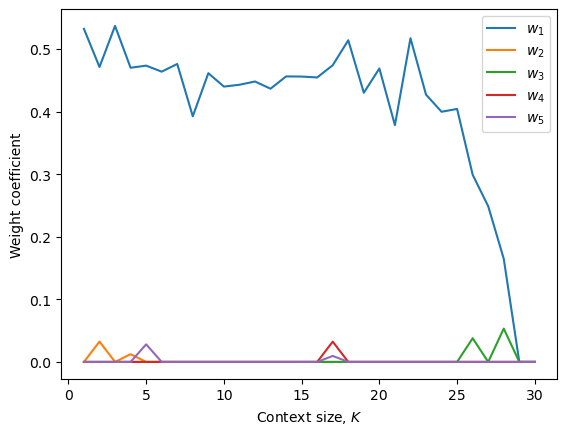

In [79]:
K_values = range(1, max_K + 1)
for i in range(5):
    plt.plot(K_values, weights[:,i])
plt.xlabel('Context size, $K$')
plt.ylabel('Weight coefficient')
plt.legend(['$w_'+str(i+1)+'$' for i in range(5)])
plt.show()

Observe that almost all coefficients $w_k$ for seasons $k$ years before the current season are effectively zero (plus noise), except for the immediately previous ($k=1$) season.
Also observe that $w_1(K)$ appears reasonable until about $K\approx 25$.

This single experiment suggests that only the ($K=1$) previous season offers any useful information to predict the current season. However, a single experiment may be spuriously  affected by
possibly unrepresentative sampling.
In order to try to overcome this problem, we now repeat the experiment multiple times and average over the results.

In [80]:
def run_multiple_experiments(team_data, num_experims, max_K, val_frac):
    all_est_scores =[]
    all_val_scores = []
    all_num_data = []

    for i in range(num_experims):
        print("Running experiment", i + 1, "...")
        _, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)
        all_est_scores.append(est_scores)
        all_val_scores.append(val_scores)
        all_num_data.append(num_data)

    all_est_scores = np.mean(all_est_scores, axis=0)
    all_val_scores = np.mean(all_val_scores, axis=0)
    all_num_data = np.mean(all_num_data, axis=0)
    
    return all_est_scores, all_val_scores, all_num_data

In [81]:
num_experims = 20
max_K = 25

est_scores, val_scores, num_data = run_multiple_experiments(team_data, num_experims, max_K, val_frac)

Running experiment 1 ...
Running experiment 2 ...
Running experiment 3 ...
Running experiment 4 ...
Running experiment 5 ...
Running experiment 6 ...
Running experiment 7 ...
Running experiment 8 ...
Running experiment 9 ...
Running experiment 10 ...
Running experiment 11 ...
Running experiment 12 ...
Running experiment 13 ...
Running experiment 14 ...
Running experiment 15 ...
Running experiment 16 ...
Running experiment 17 ...
Running experiment 18 ...
Running experiment 19 ...
Running experiment 20 ...


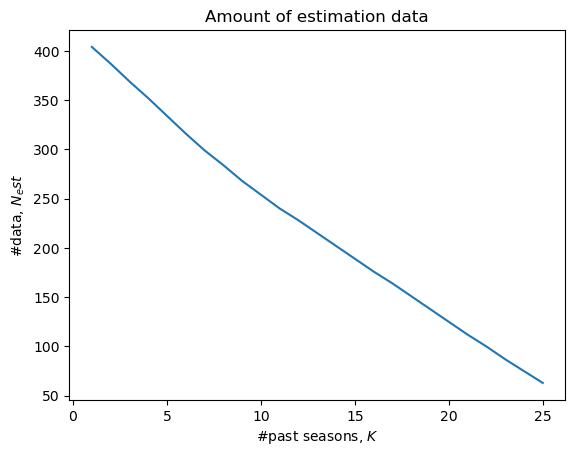

In [82]:
K_values = range(1, max_K + 1)
plt.plot(K_values, num_data)
plt.title("Amount of estimation data")
plt.xlabel("#past seasons, $K$")
plt.ylabel("#data, $N_est$")
plt.show()

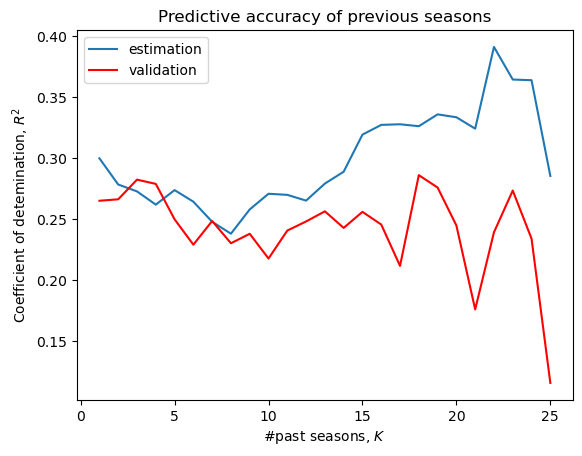

In [83]:
plt.plot(K_values, est_scores)
plt.plot(K_values, val_scores, 'r')
plt.title("Predictive accuracy of previous seasons")
plt.xlabel("#past seasons, $K$")
plt.ylabel("Coefficient of detemination, $R^2$")
plt.legend(['estimation', 'validation'])
plt.show()

Due to the randomisation, the experimental results vary at each run. Generallly, however,
we observe that the model behaves reasonably well for increasing $K$ until about $K\approx 15$, whereupon the validation score starts decreasing whilst the training score keeps increasing, indicating over-fittng (due to limited data). 
Note that for $K>25$ (not shown), the validation score actually becomes negative, as the 
model becomes worse than chance in explaining the residual variation.

We conclude that there appears to be little merit in using more than $K=1$ past seasons for a weighted, additive model. Other experiments (not shown here) also rule out using a weighted, multiplicative model. This is not unexpected, since, as noted at the end of the
[previous](#Temporal-averaging "Section: Temporal averaging") section,
a multiplicative weighting of probability estimates may be
transformed into an additively weighted model using the *logit* function. In other words, the predicted probability may also be represented via a *logistic* model of transformed probability estimates. However, this nonlinear transformation is clearly insufficient to extract further information from the seasonal time-series.

We have not yet ruled out other forms of multi-seasonal modelling, such as macro-averaging of statistics or analytics on multi-season match graphs. However, once again, other experiments (not shown here) suggest that the inclusion of further past seasons tends to add more noise to the
existing variation in the current season, and this extra variation degrades model performance.

Despite this, there might still be useful information hidden in the historical data. For example, if team A has never yet defated team B on team B's home ground, then this might be a strong indicator that team A's probability of doing so in the future is low, and we might be able to quantify this effect. 